In [37]:
import numpy as np
import torch
from torchvision import transforms, models, datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [38]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
CUDA_LAUNCH_BLOCKING=1

In [39]:
root = "./images/icemodelimages"
transformation = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()])
data = datasets.ImageFolder(root = root, transform=transformation)
torch.save(data, "data.pt")
data = torch.load('data.pt')
test_size = int(0.2 * len(data))
train_size = len(data) - test_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])



In [40]:
#Create additional layers for snow classification
model = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False   

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2),
    torch.nn.Softmax(dim= 1)
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
#parameters

lr = 0.0003
batch_size = 256
epochs =10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 1, shuffle= False)

In [50]:
def calc_test_accuracy(model, dataloader,epoch, save_pic = False, criterion =torch.nn.CrossEntropyLoss()):
      model.eval()
      TP = 0
      FP = 0
      TN = 0
      FN = 0
      val_loss = 0
      with torch.no_grad():
            for num, (i, l) in enumerate(dataloader):
                  if(save_pic):     
                        plt.imsave(f"image{num}.png",i.squeeze(0).permute(1,2,0).numpy() )
                 
                  if(l == torch.tensor([0])):
                        l = torch.tensor([1, 0])
                  else:
                        l = torch.tensor([0, 1])
                  l = l.reshape([1,2])
                  i,l = i.to(device), l.to(device).float()
                  t_out = model(i)
                  
                  
                  val_loss+= criterion(t_out, l).item()
                  predicted = np.argmax(t_out.cpu().numpy(), axis = 1)
                  true_label = np.argmax(l.cpu().numpy(), axis =1)
                  
                  if(predicted == 1 and true_label == 1):
                        
                        TP +=1
                  elif(predicted == 0 and true_label == 0):
                        TN +=1
                  if(predicted == 1 and true_label == 0):
                        FP +=1
                        plt.imsave(f"imageFP{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
                  elif(predicted == 0 and true_label == 1):
                        FN +=1
                        plt.imsave(f"imageFN{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
                  
            stats = dict(
                  epoch = epoch,
                  accuracy = (TN+TP) /(TP+TN+FP+FN),
                  precision = TP/(TP + FP),
                  recall = TP/(TP + FN),
                  loss = val_loss/(TP+FP+TN+FN)
            
            )
            # print(f'True positives: {TP}')
            # print(f'True negatives: {TN}')
            # print(f'False positives: {FP}')
            
            # print(f'False negatives: {FN}')
            return stats


In [43]:

#training loop
running_loss = 0 
train_loss, test_loss = [],[]
model.train()
verbose = 10
steps = 0

for epoch in range(epochs):
    print(epoch)
    for images,labels in train_loader:
        steps +=1
        labels = torch.nn.functional.one_hot(labels)
        images,labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    val_loss = 0
    num_correct = 0
    model.eval()
    train_loss.append(running_loss/len(train_loader))
    if(epoch %2 == 0):
        with torch.no_grad():
            print('here')
            stats = calc_test_accuracy(model, test_loader, epoch+1)
            
            test_loss.append(stats["loss"])
            stats["training_loss"] = train_loss
            torch.save(stats, f"stats-{epoch+1}.pt")
    running_loss= 0
    model.train()
    torch.save(model, 'model.pth')
    
  


        
    

0
here
1
2
here
3
4
here
5
6
here
7
8
here
9


In [51]:
model = torch.load('model.pth')
stats = calc_test_accuracy(model, test_loader, epoch+1)
print(stats)



{'epoch': 10, 'accuracy': 0.9746478873239437, 'precision': 0.9577039274924471, 'recall': 0.9875389408099688, 'loss': 0.3476980721866581}


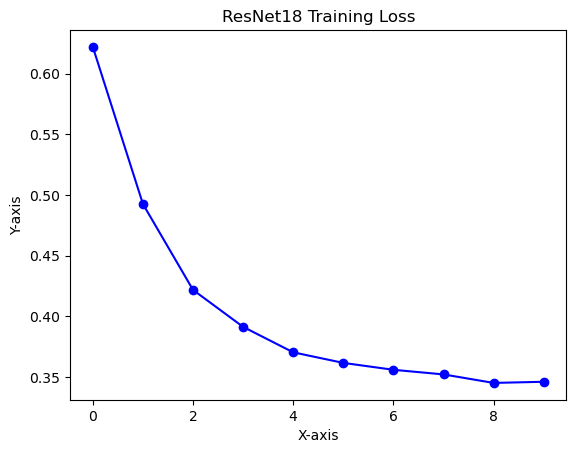

In [48]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(train_loss, marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('ResNet18 Training Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

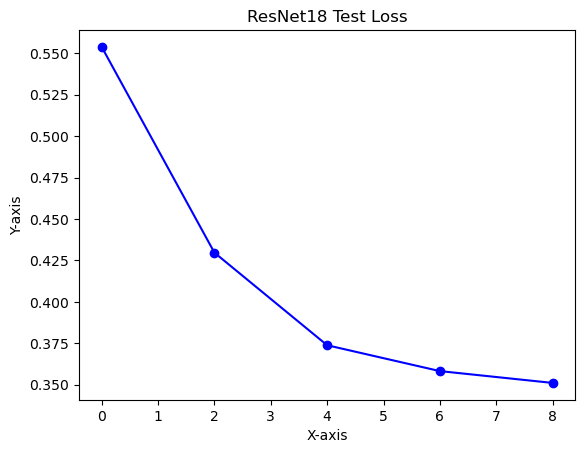

In [49]:
fig, ax = plt.subplots()

# Plot the data
ax.plot([0,2,4,6,8],test_loss,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('ResNet18 Test Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()